<a href="https://colab.research.google.com/github/sonG1031/ML_DL_STUDY/blob/main/%ED%95%A9%EC%84%B1%EA%B3%B1%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

합성곱 층은 여러 개의 필터를 사용해 이미지에서 특징을 학습한다.  
각 필터는 커널이라 부르는 가중치와 절편을 가지고 있다.  
일반적으로 절편은 시각적으로 의미가 있지 않고,  
**가중치는 입력 이미지의 2차원 영역에 적용되어 어떤 특징을 크게 두드러지게 표현하는 역할을 한다.**

In [1]:
# 모델 가져오기
from tensorflow import keras

model = keras.models.load_model('./drive/MyDrive/best-cnn-model.h5')

In [ ]:
# 모델에 추가한 층 확인하기
model.layers

### 첫 번째 합성곱 층의 가중치를 조사하기
층의 가중치와 절편은 층의 weights 속성에 저장되어 있다.  
첫 번째 원소는 가중치, 두 번째 원소는 절편이다.

In [ ]:
conv = model.layers[0]
print("가중치의 크기 :", conv.weights[0].shape)
print("절편의 크기 :", conv.weights[1].shape)

가중치의 크기 : (3, 3, 1, 32)
절편의 크기 : (32,)


첫 번째 층에서 커널의 크기를 (3,3)으로 지정했고, 합성곱 층에 전달되는 입력의 깊이는 1이다.  
따라서 실제 커널의 크기는 (3,3,1)이지만 필터 개수가 32개 이므로 weights의 가중치 크기는 (3,3,1,32)인 것이다.  
절편의 개수는 필터마다 1개 있으므로 (32,)인 것이다.

weights 속성은 텐서플로의 다차원 배열인 Tensor 클래스의 객체이다.  
다루기 쉽도록 numpy() 메서드를 사용하여 넘파이 배열로 변환하자.  
그다음 가중치 배열의 평균, 표준편차를 계산해보자

In [ ]:
conv_weights = conv.weights[0].numpy()
print("가중치 평균 :", conv_weights.mean())
print("가중치 표준편차 :", conv_weights.std())

가중치 평균 : -0.024862103
가중치 표준편차 : 0.23953588


나중에 이 값을 훈련하기 전의 가중치와 비교할 것이다.  
가중치가 어떤 분포를 가졌는지 직관적으로 이해하기 위해 히스토그램을 그려보자

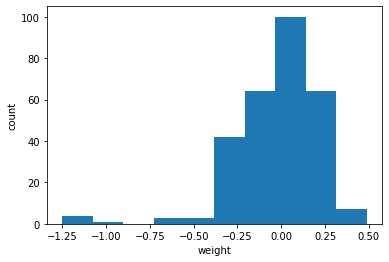

In [ ]:
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1)) # 히스토그램을 그리기 위해 1차원 배열로만 전달해야함
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

이번에는 32개의 커널을 16개씩 두 줄에 출력해보자

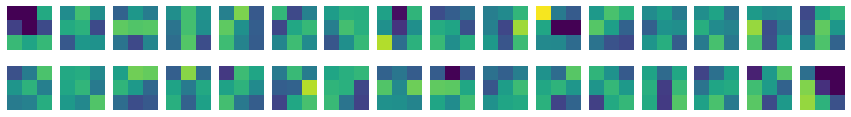

In [ ]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i,j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i,j].axis('off')
plt.show()

위의 커널들을 보면 어떤 패턴을 볼 수 있다.  
예를 들어 첫 번째 줄의 3번째 커널의 가운데 가중치들의 값을 보면 높은 것을 확인할 수 있다.  
(밝은 부분의 값이 높은 값이다.) 이 가중치는 가운데에 놓인 직선을 만나면 크게 활성화될 것이다.

imshow() 함수는 배열에 있는 최댓값과 최솟값을 사용해 픽셀의 강도를 표현한다.  
만약 두 배열을 imshow() 함수로 비교하려면 이런 동작은 바랍직하지 않다.  
어떤 절댓값으로 기준을 정해서 픽셀의 강도를 나타내야 비교하기 좋다.  
이를 위해 vmin, vmax로 맷플롯립의 컬러맵으로 표현할 범위를 지정했다.

앞서 말했듯이 비교하기 위한 빈 합성곱 신경망을 만들어보자

In [ ]:
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation=\
                                          'relu', padding='same', input_shape=(28,28,1)))

In [ ]:
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


이제 이 가중치의 평균과 표준편차를 확인해보자

In [ ]:
no_training_weights = no_training_conv.weights[0].numpy()
print("가중치의 평균 :", no_training_weights.mean())
print("가중치의 표준편차 :", no_training_weights.std())

가중치의 평균 : -0.0044432166
가중치의 표준편차 : 0.08215556


평균은 이전과 동일하게 0에 가깝지만 표준편차는 이전과 달리 매우 작다.  
히스토그램으로 분포를 확인해 보자!

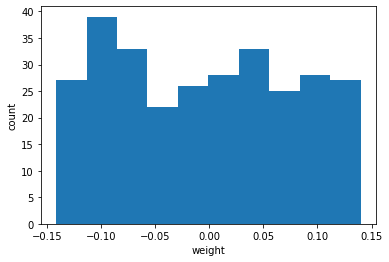

In [ ]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

비교적 고른 분포를 보인다. 그 이유는 텐서플로가 신경망의 가중치를 처음 초기화할 때 균등분포에서 랜덤하게 값을 선택하기 때문이다.  
이전처럼 커널들을 그림으로 출력해보자

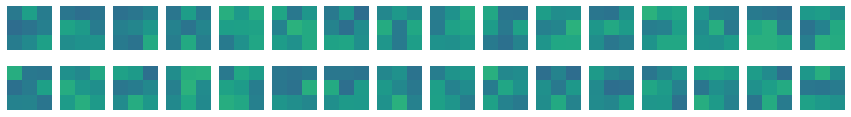

In [ ]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i,j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i,j].axis('off')
plt.show()

히스토그램에서 보이듯 전체적으로 가중치가 밋밋하게 초기화 되었다.  
이를 통해 알 수 있는 것은 훈련이 끝난 합성곱 신경망이 패션 MNIST 데이터셋의 분류 정확도를 높이기 위해 유용한 패턴을 학습했다는 사실을 눈치챌 수 있다.

### 특성맵 그려보기
합성곱 신경망의 학습을 시각화하는 두 번째 방법은 합성곱 층에서 출력된 특성 맵을 그려 보는 것이다.  
이를 통해 입력 이미지를 신경망 층이 어떻게 바라보는지 엿볼 수 있다.

#### 함수형 API(functional API)
지금까지 신경망 모델을 만들 때 케라스 Sequential 클래스를 사용했다.  
이 클래스는 층을 차례대로 쌓은 모델을 만든다. 그러나 딥러닝에서는 좀 더 복잡한 모델이 많이 있다.  
예를 들어 입력이 2개 or 출력이 2개일 수도 있다. 이런 경우는 Sequential 클래스를 사용하기 어렵다.  
이때 함수형 API를 사용한다.  

함수형 API는 케라스의 Model 클래스를 사용하여 모델을 만든다.  


예를 들어 Dense 층 2개로 이루어진 완전 연결 신경망을 함수형 API로 구현해보자  


```
dense1 = keras.layers.Dense(100, activation='sigmoid')
dense2 = keras.layers.Dense(10, activation='softmax')
```
- 위의 두 객체 층을 원래라면 Sequential 클래스 객체의 add() 메서드에 전달할 수 있다  
- 하지만 다음과 같이 함수처럼 호출할 수도 있다.(파이썬 클래스는 __ call __ 메서드를 통해 함수처럼 호출을 만들 수 있다.)  

```
hidden = dense1(inputs)
```
케라스의 층은 객체를 함수처럼 호출했을 때 적절히 동작할 수 있도록 미리 준비되어 있다.  
앞의 코드를 실행하면 입력값 inputs을 Dense층에 통과시킨 후 출력값 hidden을 만들어 준다!





이제 왜 함수형 API라고 부르는지 감이 온다.  
그다음 두번째 층을 호출하고 싶다면 첫번째 층의 출력을 입력으로 사용한다.  
```
outputs = dense2(hidden)
```

그다음 inputs와 outputs을 Model클래스로 연결해 주면 된다.  
```
model = keras.Model(inputs, outputs)
```
입력에서 출력까지 층을 호출한 결과를 계속 이어주고 Model 클래스에 입력과 최종 출력을 지정한다.

그렇다면 inputs는 어디서 온 걸까?  
plot_model() 함수로 모델의 층을 도식화했을 때 InputLayer 클래스가 맨 처음 나왔었다.  
Sequential 클래스는 InputLayer 클래스를 자동으로 추가하고 호출해 주지만  
Model 클래스는 수동으로 만들어서 호출해야한다. **즉, inputs가 InputLayer 클래스의 출력값이 되어야 한다!**

Sequential 클래스에서 InputLayer는 _layers에 첫번째 원소로 저장된다.  
InputLayer 클래스는 신경망의 입력층 역할을 한다. 즉 모델의 입력을 첫번째 은닉층에 전달하는 역할을 수행한다.

케라스는 InputLayer 클래스 객체를 쉽게 다룰 수 있도록 Input() 함수를 별도로 제공함.  
입력의 크기를 지정하는 shape 매개변수와 함께 이 함수를 호출하면 InputLayer 클래스 객체를 반환한다.  


```
inputs = keras.Input(shape=(784,))
```



이렇게 모델을 만들게 되면 중간에 다양한 형태로 층을 연결할 수 있다.  
그런데 특성 맵 시각화를 만드는 데 함수형 API가 왜 필요한 것일까?  
먼저 필요한 것은 첫번째 Conv2D의 출력(풀링하지 않은 특성 맵)이다.  
**model 객체의 입력과 Conv2D의 출력을 알 수 있다면 이 둘을 연결하여 새로운 모델을 얻을 수 있지 않을까?!**

첫 번째 층의 출력은 Conv2D 객체의 output 속성에서 얻을 수 있다.  
```
model.layers[0].output
```
model 객체의 입력은 input 속성으로 입력을 참조할 수 있다.  
즉 model.input 으로 이 모델의 입력을 간단히 얻을 수 있다.



In [2]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


이제 model.input과 model.layers\[0\].output을 연결하는 새로운 conv_acti 모델을 만들 수 있다!

In [3]:
conv_acti = keras.Model(model.input, model.layers[0].output)

원래 model 객체의 predict() 메서드를 호출하면 최종 출력층의 확률을 반환할 것이다.  
그러나 conv_acti의 predict() 메서드를 호출하면 첫번째 Conv2D의 출력을 반환할 것이다.  
이제 특성 맵을 시각화할 준비가 끝났다!

4422102/4422102 [==============================] - 0s 0us/step


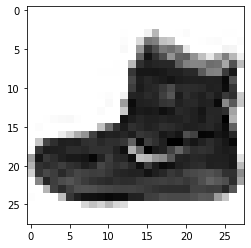

In [4]:
import matplotlib.pyplot as plt

(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

이제 Conv2D 층이 만드는 특성 맵을 출력해 보자  
predict() 메서드는 항상 입력의 첫번째 차원이 배치 차원일 것으로 기대한다.  
하나의 샘플을 전달하더라도 꼭 첫번째 차원을 유지해야하므로 슬라이싱 연산자를 사용하자  
그다음에 (784,) 크기를 (28,28,1) 크기로 변경하고 255로 나눈다(전처리 과정이므로 동일함)

In [5]:
inputs = train_input[:1].reshape(-1,28,28,1) / 255.0
feature_maps = conv_acti.predict(inputs)

1/1 [==============================] - 7s 7s/step


In [6]:
print(feature_maps.shape)

(1, 28, 28, 32)


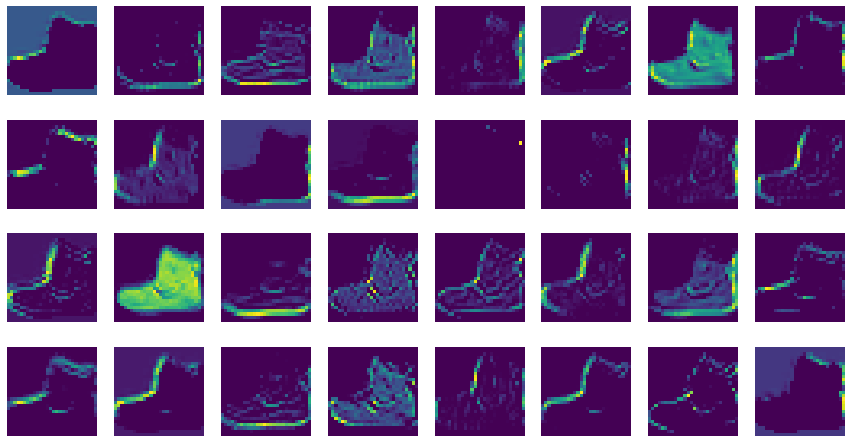

In [9]:
fig, axs = plt.subplots(4, 8, figsize=(15,8))

for i in range(4):
    for j in range(8):
        axs[i,j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i,j].axis('off')
plt.show()

두번째 합성곱 층이 만든 특성 맵도 같은 방식으로 확인 가능하다.

In [10]:
conv2_acti = keras.Model(model.input, model.layers[2].output)

In [11]:
inputs = train_input[:1].reshape(-1,28,28,1) / 255.0
feature_maps = conv2_acti.predict(inputs)

1/1 [==============================] - 0s 146ms/step


In [12]:
print(feature_maps.shape) # 이전 층이 풀링층 이므로 절반으로 너비와 높이가 줄었다.

(1, 14, 14, 64)


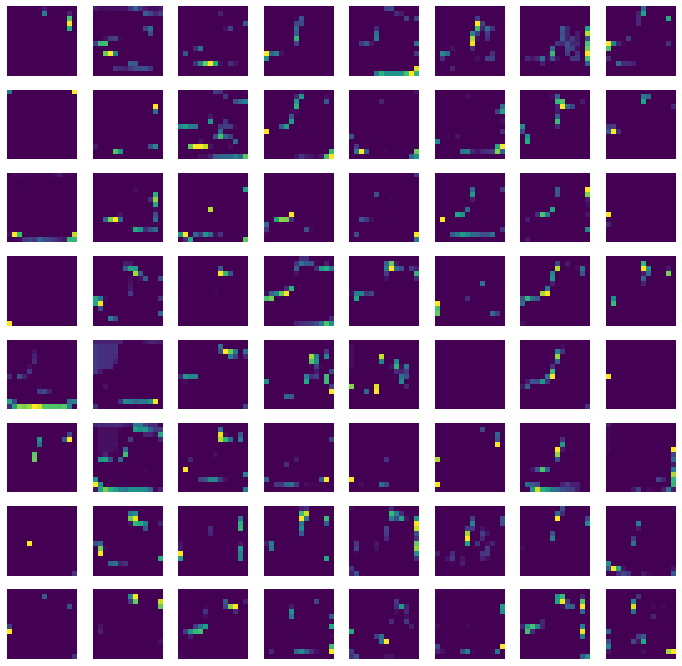

In [13]:
fig, axs = plt.subplots(8, 8, figsize=(12,12))

for i in range(8):
    for j in range(8):
        axs[i,j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i,j].axis('off')
plt.show()

이 특성 맵은 시각적으로 이해하기 어렵다. 왜 그럴까?  
두 번째 합성곱 층의 필터 크기는 (3,3,32)이다.  
두번째 합성곱 층의 첫번째 필터가 앞서 출력한 32개의 특성 맵과 곱해져 두번 째 합성곱 층의 첫 번째 특성 맵이 된다.  
따라서 어떤 부위를 감지하는지 직관적으로 이해하기가 어렵다. 이런 현상은 합성곱 층을 많이 쌓을수록 심해진다.  


이를 바꾸어 생각하면 합성곱 신경망의 앞부분에 있는 합성곱 층은 이미지의 시각적인 정보를 감지하고  
뒤쪽에 있는 합성곱 층은 앞쪽에서 감지한 시각적인 정보를 바탕으로 추상적인 정보를 학습한다고 볼 수 있다.